In [1]:
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

In [2]:
class BasicComparator(SubCircuitFactory):

    __name__ = 'BasicComparator'
    __nodes__ = ('non_inverting_input', 'inverting_input',
                 'voltage_plus', 'voltage_minus',
                 'output')


    def __init__(self,):

        super().__init__()

        # Fixme: ngspice is buggy with such subcircuit

        # Fixme: how to pass voltage_plus, voltage_minus ?
        # output_voltage_minus, output_voltage_plus = 0, 15

        # to plug the voltage source
        self.R(1, 'voltage_plus', 'voltage_minus', 1@u_MΩ)
        self.NonLinearVoltageSource(1, 'output', 'voltage_minus',
                                    expression='V(non_inverting_input, inverting_input)',
                                    # table=((-micro(1), output_voltage_minus),
                                    #       (micro(1), output_voltage_plus))
                                    table=(('-1uV', '0V'), ('1uV', '15V'))
                                )

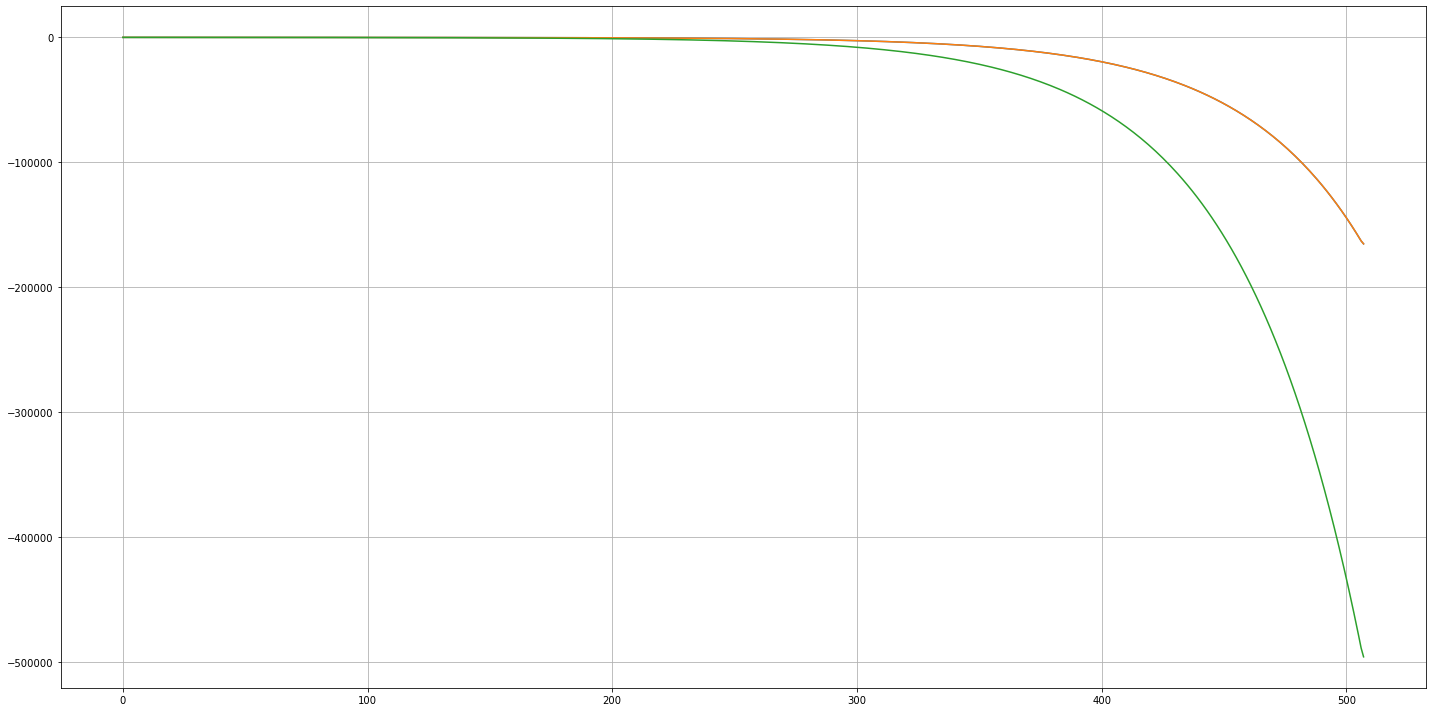

In [3]:
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# from OperationalAmplifier import basic_comparator


circuit = Circuit('Astable Multivibrator')

source = circuit.V('cc', 'vcc', circuit.gnd, 15@u_V)
# Time constant
circuit.R(1, 'output', 'comparator', 1@u_kΩ)
circuit.C(1, 'comparator', circuit.gnd, 100@u_nF)
# Reference
circuit.R(2, 'output', 'reference', 100@u_kΩ)
circuit.R(3, 'vcc', 'reference', 100@u_kΩ)
circuit.R(4, 'reference', circuit.gnd, 100@u_kΩ)
# Comparator
# Fixme: ngspice is buggy with such subcircuit
# circuit.subcircuit(basic_comparator)
# circuit.X('comparator', 'BasicComparator', 'reference', 'comparator', 'vcc', circuit.gnd, 'output')
circuit.NonLinearVoltageSource(1, 'output', circuit.gnd,
                               expression='V(reference, comparator)',
                               table=((-micro(1), 0),
                                      (micro(1), source.dc_value))
                               )

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.initial_condition(comparator=0)  # Fixme: simulator.nodes.comparator == 0
analysis = simulator.transient(step_time=1@u_us, end_time=500@u_us)
# Fixme: Xyce fails with Time step too small

figure, ax = plt.subplots(figsize=(20, 10))
ax.grid()
ax.plot(analysis.reference)
ax.plot(analysis.comparator)
ax.plot(analysis.output)

plt.tight_layout()
plt.show()